# Homework 4

In [500]:
import numpy as  np
import matplotlib.pyplot as plt

In [501]:
K = 4

theta_true = np.ones((K, 1))

In [502]:
a = 0
b = 1

N = 40
X = np.linspace(a, b, N)

In [503]:
def vander(X, K):
    phi = np.zeros((len(X), K))
    for i in range(K):
        phi[:, i] = X**i
    return phi

In [504]:
sigma_2 = 0.1

rng = np.random.default_rng()
Y = vander(X, K) @ theta_true + rng.normal(0, np.sqrt(sigma_2), size=(N, 1))

In [505]:
D = (X, Y)

In [506]:
# Define GD and STG
def GD(grad_f, w0, D, tolf, tolx, kmax, alpha=0.1):
    err_val = [np.linalg.norm(grad_f(w0))]
    
    k = 0
    x = [w0]
    
    rel_tol_cond = True
    rel_inp_cond = True
    max_it_cond = True
    
    while rel_tol_cond and rel_inp_cond and max_it_cond:
        # print(f"GD: {np.linalg.norm(grad_f(x[k]))}")
        x.append(x[k] - alpha * grad_f(x[k]))
        err_val.append(np.linalg.norm(grad_f(x[k])))
        
        k += 1
        # if(k % 100 == 0): print(f"iteration: {k}")

        rel_tol_cond = np.linalg.norm(grad_f(x[k-1])) > tolf * np.linalg.norm(grad_f(w0))
        rel_inp_cond = True if k == 0 else np.linalg.norm(x[k] - x[k-1]) > tolx
        max_it_cond = k < kmax

    return x[k], err_val

from math import ceil
def SGD(grad_l, w0, data, batch_size, n_epochs, alpha=0.01):
    X, Y = data
    X = X.reshape((1, -1))
    d, N = X.shape

    # number of epochs * iterations per epoch
    tot_iterations = ceil(n_epochs * ceil(N / batch_size))

    w = np.zeros(tot_iterations + 1, dtype=object)
    grads = np.zeros(n_epochs, dtype=object)
    err = np.zeros(n_epochs, dtype=object)

    w[0] = w0
    k = 0

    for epoch in range(n_epochs):
        # print(f"--> Epoch {epoch}")

        # Shuffle the dataset
        rng = np.random.default_rng()
        D = np.concatenate((Y, X.T), axis=1)
        rng.shuffle(D)
        X = D[:, 1:].T
        Y = D[:, 0].reshape(-1, 1)
        
        batches_num = ceil(N / batch_size)
        for batch in range(batches_num):
            Mx = X[:, batch*batch_size:(batch+1)*batch_size]
            My = Y[batch*batch_size:(batch+1)*batch_size]
            M = (Mx, My)
            # Gradient descent step
            k = (epoch * batches_num) + batch
            w[k+1] = w[k] - alpha * grad_l(w[k], M)

        grads[epoch] = grad_l(w[k+1], data)
        
        err[epoch] = np.linalg.norm(grads[epoch])
    
    return w[k+1], grads, err

In [507]:
def sample_from_normal(shape):
    rng = np.random.default_rng()
    return rng.normal(0, 1, size=shape)

In [508]:
def MLE(D, K, use_gd=False, use_sgd=False, gd_kmax = 1000, alpha=0.01, sgd_batch_size=100, sgd_n_epochs=1000):
    X, Y = D
    # X = X.reshape((1, -1))
    Phi = vander(X, K)

    def mle_gradient_GD(theta):
        return Phi.T @ (Phi @ theta - Y)
    
    def mle_gradient_SGD(theta, D):
        X, Y = D
        X = X.reshape((-1, ))
        Phi = vander(X, K)
        return Phi.T @ (Phi @ theta - Y)

    theta_0 = sample_from_normal((K, 1))

    theta_gd = None
    theta_sgd = None
    
    if use_gd: 
        theta_gd, err_gd = GD(mle_gradient_GD, theta_0, D, 0., 0., kmax=gd_kmax, alpha=alpha)
        print(f"Gradient descent error = {err_gd[-1]}")
        return theta_gd
    elif use_sgd: 
        theta_sgd, _, err_sgd = SGD(mle_gradient_SGD, theta_0, D, batch_size=sgd_batch_size, n_epochs=sgd_n_epochs, alpha=alpha)
        print(f"Stochastic gradient descent error = {err_sgd[-1]}")
        return theta_sgd
    else:
        theta_neq = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
        return theta_neq
    

In [509]:
K_guess = 3
theta_mle = MLE(D, K_guess, use_gd=True, alpha=0.001, gd_kmax=2000)

Gradient descent error = 0.18278974052444635


In [510]:
def avg_abs_error(theta, test_data):
    X_test, Y_test = test_data
    K_test = len(theta)
    N_test = len(X_test)
    Phi = vander(X_test, K_test)
    return 1/N_test * np.power(np.linalg.norm(Phi @ theta - Y_test), 2)

In [511]:
# Generate test data
N_test = N // 2

rng = np.random.default_rng()

X_test = (b-a) * rng.random(size=(N_test, )) + a
Y_test = vander(X_test, K) @ theta_true + rng.normal(0, np.sqrt(sigma_2), (N_test, 1))

In [512]:
avg_abs_error(theta_mle, (X_test, Y_test))

0.050422893974468544

In [513]:
# Plot with different Ks
K1 = 2
theta_mle_K1 = MLE(D, K1)
Phi_K1 = vander(X, K1)

K2 = 5
theta_mle_K2 = MLE(D, K2)
Phi_K2 = vander(X, K2)

K3 = 20
theta_mle_K3 = MLE(D, K3)
Phi_K3 = vander(X, K3)

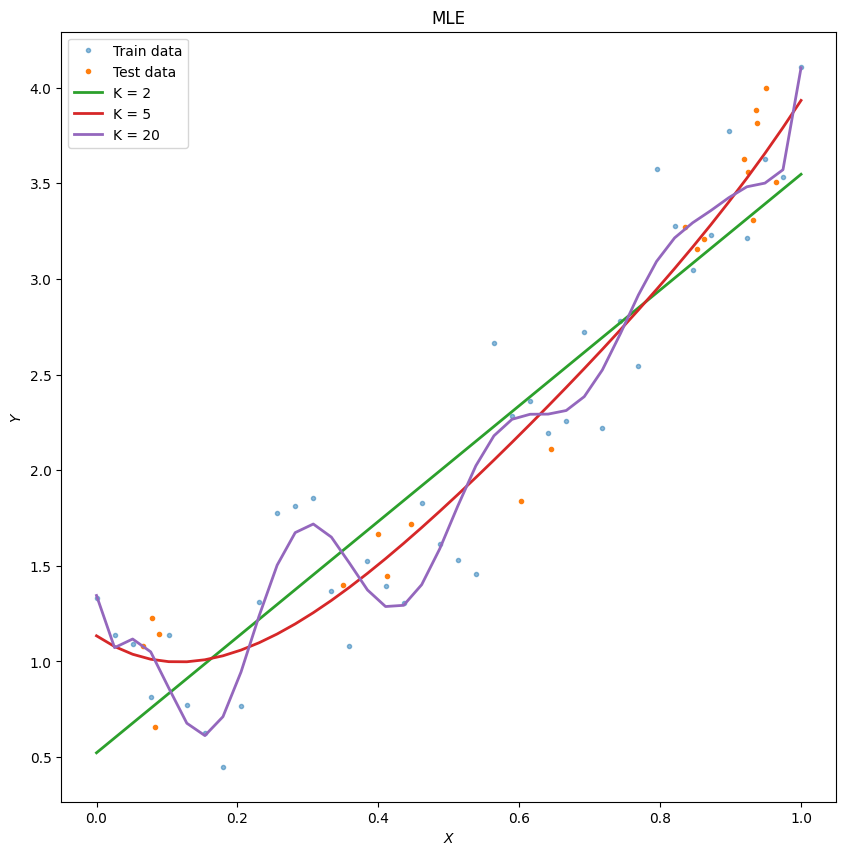

In [514]:
plt.figure(figsize=(10, 10))
plt.title("MLE")
plt.plot(X, Y, ".", label="Train data", alpha=0.5)
plt.plot(X_test, Y_test, ".", label="Test data")
plt.plot(X, Phi_K1 @ theta_mle_K1, label=f"K = {K1}", lw=2)
plt.plot(X, Phi_K2 @ theta_mle_K2, label=f"K = {K2}", lw=2)
plt.plot(X, Phi_K3 @ theta_mle_K3, label=f"K = {K3}", lw=2)
plt.legend()
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.show()

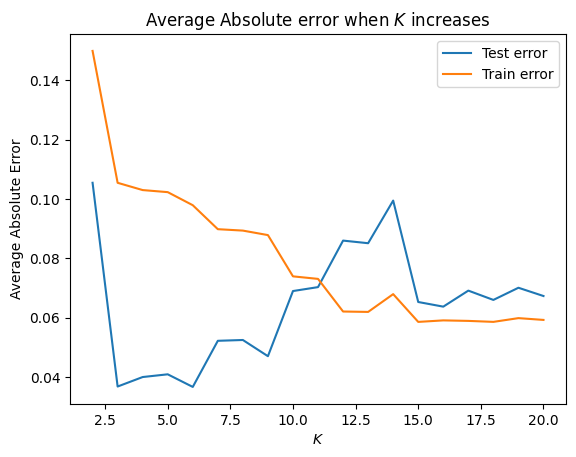

In [515]:
K_min = 2
K_max = 20
K_range = range(K_min, K_max + 1)

test_error = np.zeros((K_max - K_min + 1, ))
train_error = np.zeros((K_max - K_min + 1, ))

for K_trial in K_range:
    theta_mle_trial = MLE(D, K_trial, use_gd=False)
    test_error[K_trial - K_min] = avg_abs_error(theta_mle_trial, (X_test, Y_test))
    train_error[K_trial - K_min] = avg_abs_error(theta_mle_trial, D)

plt.title("Average Absolute error when $K$ increases")
plt.xlabel("$K$")
plt.ylabel("Average Absolute Error")
plt.plot(K_range, test_error, label="Test error")
plt.plot(K_range, train_error, label="Train error")
plt.legend()
plt.show()

In [516]:
def MAP(D, K, lb, use_gd=False, use_sgd=False):
    X, Y = D
    # X = X.reshape((1, -1))
    Phi = vander(X, K)
    

    def mle_gradient_GD(theta):
        return Phi.T @ (Phi @ theta - Y) + lb * theta
    
    def mle_gradient_SGD(theta, D):
        X, Y = D
        X = X.reshape((-1, ))
        Phi = vander(X, K)
        return Phi.T @ (Phi @ theta - Y) + lb * theta

    theta_0 = sample_from_normal((K, 1))
    
    if use_gd: 
        theta_gd, err_gd = GD(mle_gradient_GD, theta_0, D, 0., 0., 1000, alpha=0.005)
        print(f"Gradient descent error = {err_gd[-1]}")
        return theta_gd
    elif use_sgd: 
        theta_sgd, _, err_sgd = SGD(mle_gradient_SGD, theta_0, D, batch_size=10, n_epochs=1000, alpha=0.005)
        print(f"Stochastic gradient descent error = {err_sgd[-1]}")
        return theta_sgd
    else:
        theta_neq = np.linalg.solve(Phi.T @ Phi + np.identity(K) * lb, Phi.T @ Y)
        return theta_neq

In [517]:
lam_list = [0.1, 1, 30]
K_map_list = [3, 10, 150]

K = 3
lambda = 0.1
lambda = 1
lambda = 30
K = 10
lambda = 0.1
lambda = 1
lambda = 30
K = 150
lambda = 0.1
lambda = 1
lambda = 30


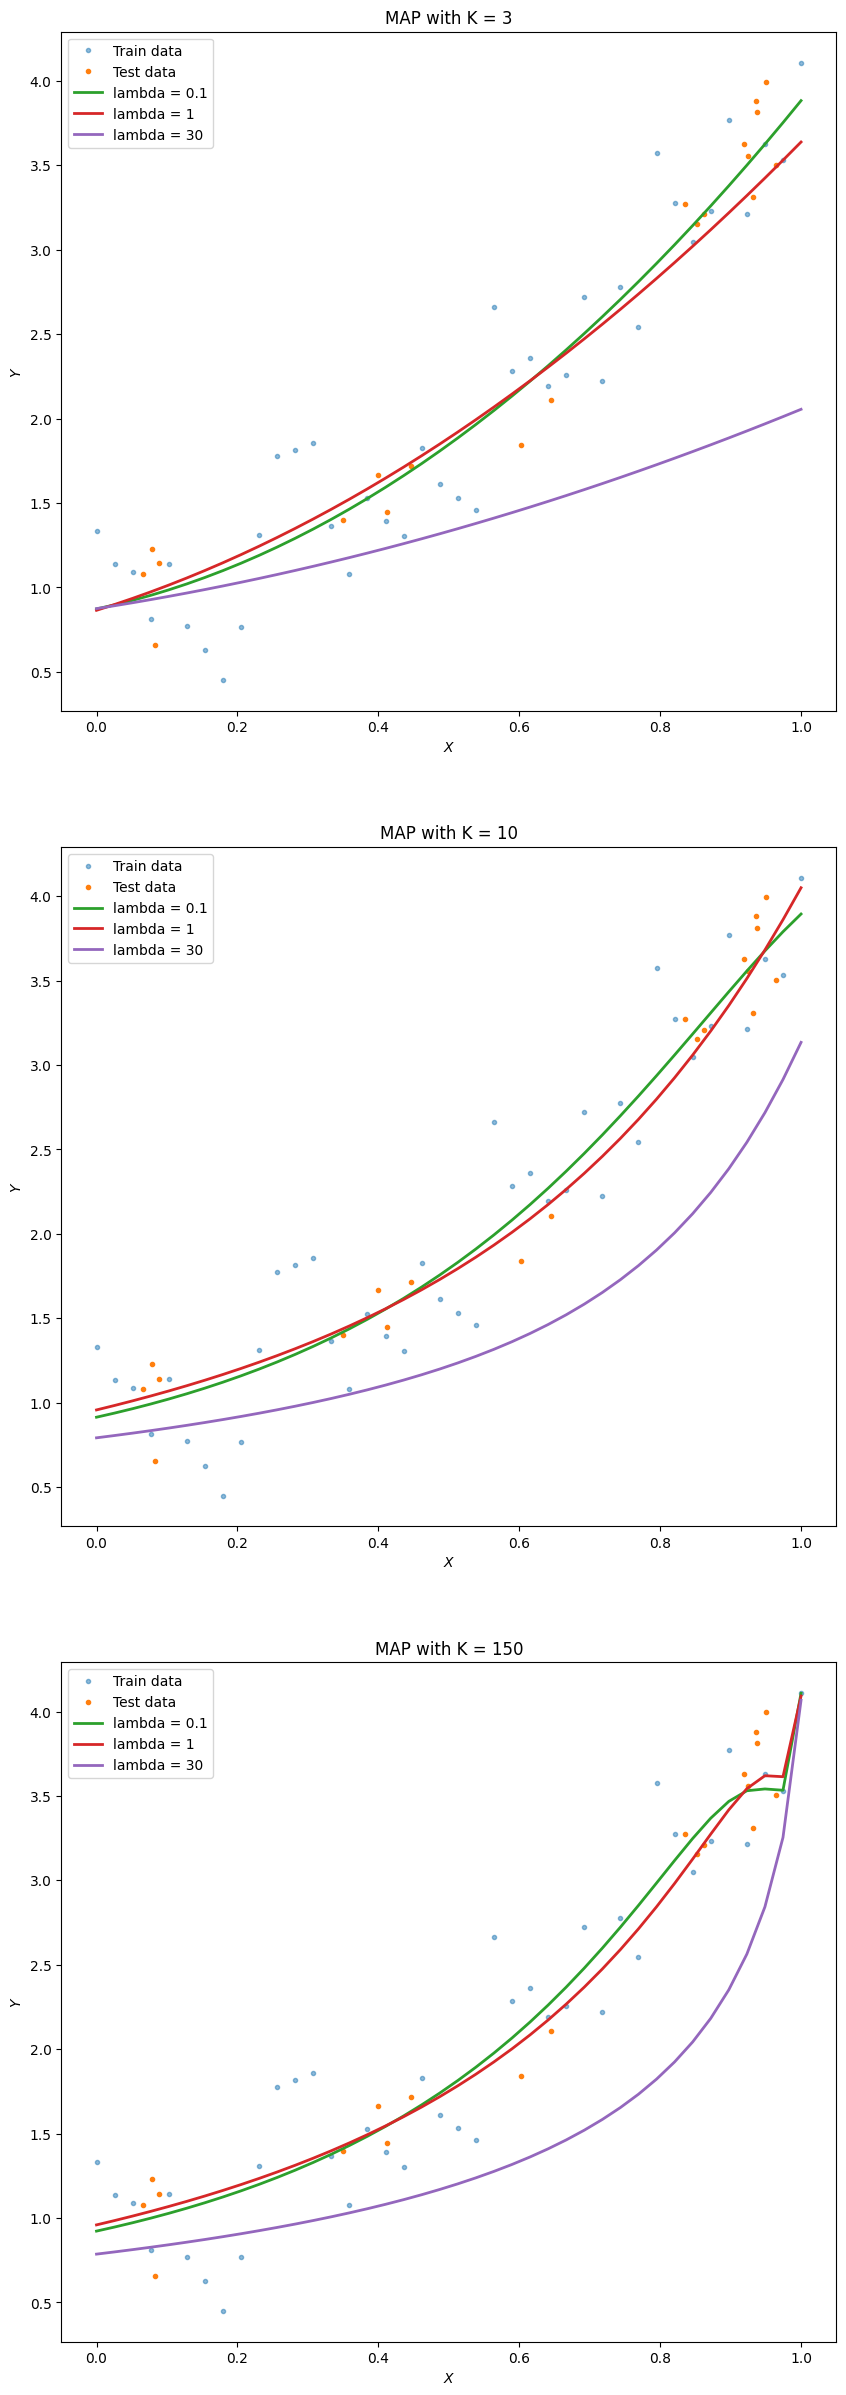

In [528]:
fig, ax = plt.subplots(len(K_map_list), 1, figsize=(10, 30))

for i, K_map in enumerate(K_map_list):
    ax[i].set_title(f"MAP with K = {K_map}")
    ax[i].plot(X, Y, ".", label="Train data", alpha=0.5)
    ax[i].plot(X_test, Y_test, ".", label="Test data")
    print(f"K = {K_map}")
    # Iterate on lambda
    for lamb in lam_list:
        print(f"lambda = {lamb}")
        Phi_map = vander(X, K_map)
        theta_map = MAP(D, K_map, lamb)
        ax[i].plot(X, Phi_map @ theta_map, label=f"lambda = {lamb}", lw=2)


    ax[i].legend()
    ax[i].set_xlabel("$X$")
    ax[i].set_ylabel("$Y$")

# plt.plot(X, Phi_map @ theta_map, label=f"K = {K_map}, lambda = {lamb}")

In [519]:
K_test = 150
print(f"MAP and MLE errors when K = {K_test}, the correct degree is {K}")

theta_mle = MLE(D, K_test)
error_mle = avg_abs_error(theta_mle, (X_test, Y_test))
print(f"MLE error \t\t--> {error_mle}")

for lamb in lam_list:
    theta_map = MAP(D, K_test, lamb)
    error_map = avg_abs_error(theta_map, (X_test, Y_test))
    print(f"MAP error\n   lambda = {lamb}   \t--> {error_map}")

MAP and MLE errors when K = 150, the correct degree is 4
MLE error 		--> 10750.123337258905
MAP error
   lambda = 0.1   	--> 0.04186170814257596
MAP error
   lambda = 1   	--> 0.03488430417416123
MAP error
   lambda = 30   	--> 0.6377205073061614


In [520]:
def error_theta(theta_true, theta):
    len_diff = len(theta) - len(theta_true)
    filler = np.zeros((len_diff, 1))
    theta_true = np.concatenate((theta_true, filler))
    return np.linalg.norm(theta - theta_true) / np.linalg.norm(theta_true)

In [521]:
K_min = K + 1
K_max = 15
K_range = range(K_min, K_max, 1)

errors_mle = []
errors_map = [[] for _ in lam_list]

for K_trial in K_range:
    print(f"==> K = {K_trial}")
    theta_mle = MLE(D, K_trial, use_gd=False)
    print(f"MLE error = {error_theta(theta_true, theta_mle)}")
    errors_mle.append(error_theta(theta_true, theta_mle))

    for i, lamb in enumerate(lam_list):
        theta_map = MAP(D, K_trial, lamb)
        print(f"MAP error (lambda = {lamb}) = {error_theta(theta_true, theta_map)}")
        errors_map[i].append(error_theta(theta_true, theta_map))

    # errors.append((mle_error, map_errors))

==> K = 5
MLE error = 9.492671426190952
MAP error (lambda = 0.1) = 0.21046379276596305
MAP error (lambda = 1) = 0.3124928158149143
MAP error (lambda = 30) = 0.5029259605559437
==> K = 6
MLE error = 96.46025163419104
MAP error (lambda = 0.1) = 0.23207822872558168
MAP error (lambda = 1) = 0.3363136820790135
MAP error (lambda = 30) = 0.5328350164300718
==> K = 7
MLE error = 745.1973870257661
MAP error (lambda = 0.1) = 0.280847894187716
MAP error (lambda = 1) = 0.3356180380926705
MAP error (lambda = 30) = 0.5514948901101295
==> K = 8
MLE error = 428.1715599794947
MAP error (lambda = 0.1) = 0.3175141510304111
MAP error (lambda = 1) = 0.3336758429153034
MAP error (lambda = 30) = 0.5637874894053815
==> K = 9
MLE error = 9219.669269660195
MAP error (lambda = 0.1) = 0.33540602478764175
MAP error (lambda = 1) = 0.33469634818150074
MAP error (lambda = 30) = 0.5722017661714722
==> K = 10
MLE error = 160837.64819849285
MAP error (lambda = 0.1) = 0.3392505293154328
MAP error (lambda = 1) = 0.3381938

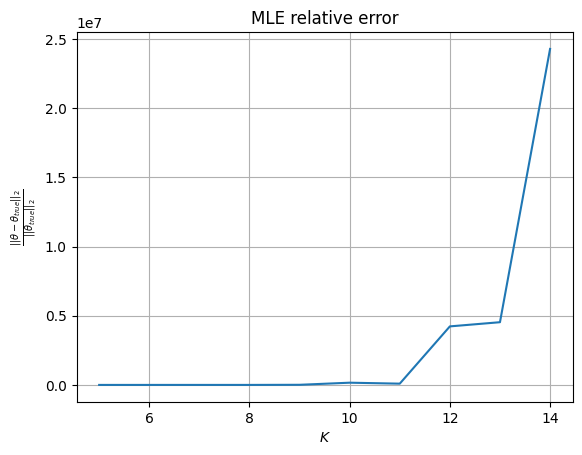

In [524]:
plt.title("MLE relative error")
plt.plot(K_range, errors_mle)
plt.xlabel("$K$")
plt.ylabel("$\\frac{||\\theta - \\theta_{true}||_2}{||\\theta_{true}||_2}$")
plt.grid()

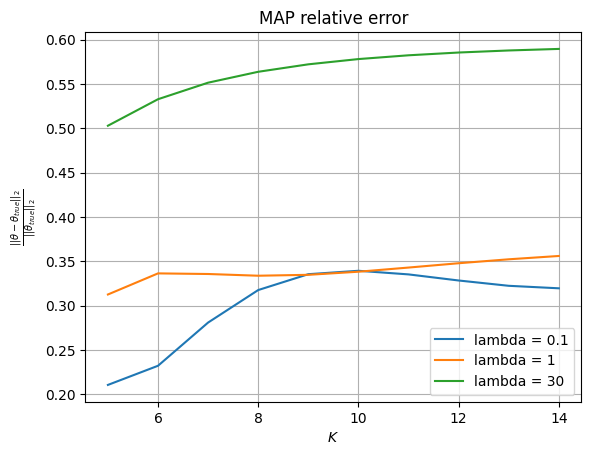

In [525]:
plt.title("MAP relative error")
for errs, lam in zip(errors_map, lam_list):
    plt.plot(K_range, errs, label=f"lambda = {lam}")
    
plt.xlabel("$K$")
plt.ylabel("$\\frac{||\\theta - \\theta_{true}||_2}{||\\theta_{true}||_2}$")
plt.legend()
plt.grid()